## Import CTH-UHB Intrapartum CTG Records

This notebook provides an example of importing a FHR and UC record from the open CTH-UHB Intrapartum database on PhysioNet. 

In [1]:
%matplotlib inline

#Import the waveform database library
import wfdb
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
#Load Physionet databases recognized by the library
dblist = wfdb.getdblist()

In [ ]:
#Print List of databases
print (dblist)

In [ ]:
#Download the desired database to a local directory
wfdb.dldatabase('ctu-uhb-ctgdb', '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData', records = 'all', annotators = 'all',
           keepsubdirs = True, overwrite = False)


In [2]:
#Set path to downloaded data
path = '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData'

In [3]:
#Create a record object by reading one subjects data
record = wfdb.rdsamp(path + '/1017', sampfrom=0, sampto=None, channels=None,
                physical=True, pbdir = None, m2s=True)


In [ ]:
#Use wfdb library to plot records
wfdb.plotrec(record)

In [4]:
#Print and Gather some useful record characteristics
#View sampling frequency
print (record.fs)
#FHR Signal Length
#First column of p_signals is FHR
siglen = len(record.p_signals[:,0])
print(siglen)
#std = np.std(a[:,0])
#print(std)
#a = np.mean(a[np.nonzero(a[:,0])])
#print(a)

headerInfo=record.comments
#Isolate pH
pHstring = headerInfo[2]
pHmatch=re.search('pH\s*(\d+.\d+)',pHstring)
pHmatch2= re.search('pH\s*(\d+)',pHstring)
if pHmatch:
    pH = float(pHmatch.group(1))
if pHmatch2:
    ph = float(pHmatch2.group(1))
print("ph found:",ph)

#Pos stage II- This is position in raw signal sample not an index of an array
posStage2String = headerInfo[40]
posStage2 = re.search('Pos. II.st.\s*(\d+)',posStage2String)
if posStage2:
    posStage2 = int(posStage2.group(1))
print("Position of Stage II is:",posStage2)

#Delivery Type
delTypeString = headerInfo[36]
delType = re.search('Deliv. type\s*(\d+)',delTypeString)
if delType:
    delType = int(delType.group(1))
print("Delivery Type is",delType)

4
21600
ph found: 7.0
Position of Stage II is: 14400
Delivery Type is 1


In [5]:
#Separate Stage I Signal
Stage1Sig = record.p_signals[0:posStage2,0]
Stage1len = len(Stage1Sig)
#print("Length of Stage I is: ",Stage1len," datapoints and ", Stage1len)/4, " sec")))
print("Length of Stage I is: %d datapoints and %.2f seconds" % (Stage1len,Stage1len/4))
#Separate Stage II Signal
Stage2Sig = record.p_signals[posStage2:,0]
Stage2len = len(Stage2Sig)
print("Length of Stage 2 is: %d datapoints and %.2f seconds" % (Stage2len,Stage2len/4))

Length of Stage I is: 14400 datapoints and 3600.00 seconds
Length of Stage 2 is: 7200 datapoints and 1800.00 seconds


In [6]:
#Set Time Length to remove samples from beginning or end of sample
#This is time potentially confounding signal if equipment just started/ended acquisition

#Define Excluded Time-Frame in seconds and number of samples
excTimeFrameSecs = 150
excTimeFrameSamp = 150*4
#Compress by removing zero elements from each when a signal was not able to be acquired
Stage1SigTrim = Stage1Sig[excTimeFrameSamp:]
print("Stage I trimmed length is: %d datapoints and %.2f seconds" % (len(Stage1SigTrim),len(Stage1SigTrim)/4))
Stage2SigTrim = Stage2Sig[0:Stage2len-excTimeFrameSamp]
print("Stage II trimmed length is: %d datapoints and %.2f seconds" % (len(Stage2SigTrim),len(Stage2SigTrim)/4))

#Compress each Signal by removing zero elements
Stage1SigComp = Stage1SigTrim[np.nonzero(Stage1SigTrim)]
Stage2SigComp = Stage2SigTrim[np.nonzero(Stage2SigTrim)]
print("Stage I Compressed length is: %d datapoints and %.2f seconds" % (len(Stage1SigComp),len(Stage1SigComp)/4))
print("Stage II Compressed length is: %d datapoints and %.2f seconds" % (len(Stage2SigComp),len(Stage2SigComp)/4))



Stage I trimmed length is: 13800 datapoints and 3450.00 seconds
Stage II trimmed length is: 6600 datapoints and 1650.00 seconds
Stage I Compressed length is: 13381 datapoints and 3345.25 seconds
Stage II Compressed length is: 3908 datapoints and 977.00 seconds


In [7]:
Stage1FHRMean = np.mean(Stage1SigComp)
Stage1HRV = np.std(Stage1SigComp)
Stage2FHRMean = np.mean(Stage2SigComp)
Stage2HRV = np.std(Stage2SigComp)

print("Stage I Compressed Signal Mean: %.2f and HRV: %.2f" % (Stage1FHRMean,Stage1HRV))
print("Stage 2 Compressed Signal Mean: %.2f and HRV: %.2f" % (Stage2FHRMean,Stage1HRV))


Stage I Compressed Signal Mean: 159.60 and HRV: 20.38
Stage 2 Compressed Signal Mean: 116.73 and HRV: 20.38


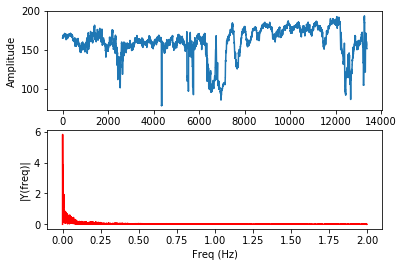

In [14]:
Fs = record.fs  # sampling rate
Ts = 1.0/Fs # sampling interval
n = len(Stage1SigComp) # length of the signal
t = np.arange(0,n) # time vector
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range
Y = np.fft.fft(Stage1SigComp-Stage1FHRMean)/n # fft computing and normalization
Y = Y[range(int(n/2))]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,Stage1SigComp)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

#plt.plot(frq,Y)


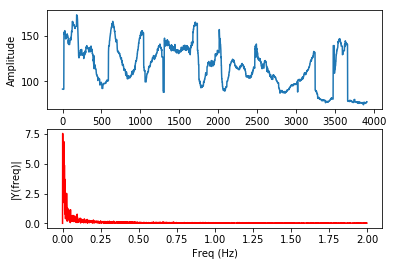

In [16]:
Fs = record.fs  # sampling rate
Ts = 1.0/Fs # sampling interval
n = len(Stage2SigComp) # length of the signal
t = np.arange(0,n) # time vector
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range
Y = np.fft.fft(Stage2SigComp-Stage2FHRMean)/n # fft computing and normalization
Y = Y[range(int(n/2))]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,Stage2SigComp)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

#plt.plot(frq,Y)

In [ ]:
#List Signal Length
print (record.siglen)
#List record comments
print (record.comments)

In [ ]:
#Alternate way of loading a record
#Output signal as a numpy array, and a dictionary of fields describing signal
sig, fields = wfdb.srdsamp(path + '/1003')

In [ ]:
#view length of FHR signal
len(sig)

In [ ]:
#view dictionary
fields

In [ ]:
#view the sampling frequency field
fields['fs']